In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from transitfit.kepler import KeplerTransitModel

In [4]:
model = KeplerTransitModel(1422)

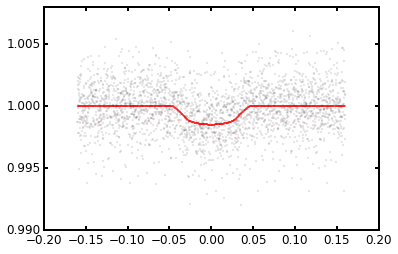

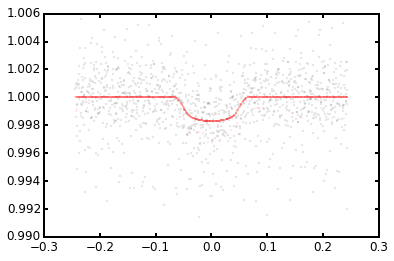

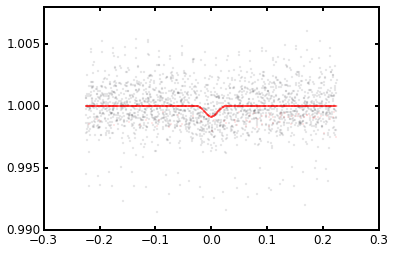

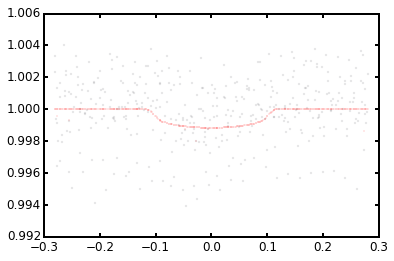

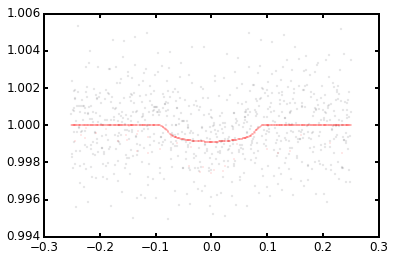

In [5]:
f = model.archive_light_curve(model.time)

for i in range(model.n_planets):
    plt.figure()
    tfold = model.tfold(i) #times folded on proper period 
    close = model.close(i) #points close to transit
    plt.plot()
    plt.plot(tfold[close], model.flux[close], 'o', ms=0.2, alpha=0.35);
    plt.plot(tfold[close], f[close], 'ro', ms=0.2, mec='r', mew=0.5);
    


5.84164124 135.92243
250.0
193.0
48060
48250.0


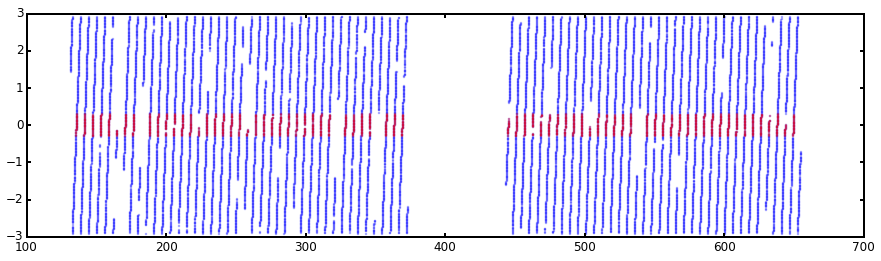

In [3]:
def transit_stack(t, f, period, epoch, width=0.3):
    """reshapes t, f to (Ntransit x npoint) 2d array
    
    Places the transit epoch at the center of each row,
    with the first and last rows padded by ones.
    
    
    """
    print period, epoch
    ntransits = ((t[-1] - t[0]) // period) + 1
    print ntransits

    rowsize = len(t)//ntransits + 1
    print rowsize
    print len(t)
    print 250*rowsize
    
    middle = rowsize//2
    # How many points do we need to add to the front to
    #  get epoch in middle?
    firstfew = t[:rowsize*100]
    i_epoch = np.argmin((firstfew - epoch) % period)
    
    tfold = (firstfew - epoch) % period
    tfold = t_folded(firstfew, period, epoch)
    close = np.absolute(tfold) < width
    plt.figure(figsize=(15,4))
    plt.plot(firstfew, tfold, '.', ms=0.5)
    plt.plot(firstfew[close], tfold[close], 'r.', ms=0.5)
    
transit_stack(model.time, model.flux, model.period[0], model.epoch[0])
    
    

In [18]:
%timeit f[anyclose] = model.light_curve(params, lcdata['TIME'][anyclose])
%timeit f[~anyclose] = model.light_curve(params, lcdata['TIME'][~anyclose])
%timeit f = model.light_curve(params, lcdata['TIME'])

10 loops, best of 3: 131 ms per loop
100 loops, best of 3: 3.39 ms per loop
10 loops, best of 3: 133 ms per loop


In [20]:
from scipy.optimize import minimize
def obj(p):
    return -model.lnlike(p)

fit = minimize(obj, params, method='Nelder-Mead', options={'disp':True})

Optimization terminated successfully.
         Current function value: 0.006263
         Iterations: 696
         Function evaluations: 1143


[  4.72954152e+00   2.81073558e-01   5.87961813e-01   1.91477839e-04
   5.84164158e+00   1.35923004e+02   5.74815816e-01   3.54667764e-02
   9.97333917e-03   9.56463017e-04]


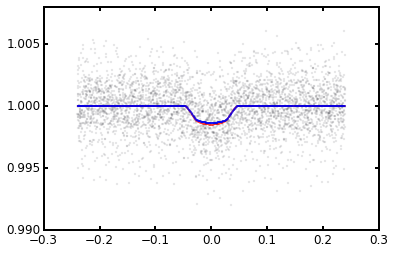

In [21]:
f_fit = np.ones_like(lcdata['TIME'])
f_fit[anyclose] = model.light_curve(fit.x, lcdata['TIME'][anyclose])

print fit.x

for period, epoch, duration in zip(periods, epochs, durations):
    plt.figure()
    tfold = (lcdata['TIME'] + period/2 - epoch) % period - (period/2)
    close = np.array(np.absolute(tfold) < 3*(duration/24))
    plt.plot(tfold[close], flux[close], 'o', ms=0.2, alpha=0.35);
    plt.plot(tfold[close], f[close], 'ro', ms=0.2, mec='r', mew=0.2);
    plt.plot(tfold[close], f_fit[close], 'bo', ms=0.2, mec='b', mew=0.4)

In [59]:
import emcee as emcee

ndim = len(params)
nwalkers = 100
p0 = (1 + np.random.normal(0,0.01,size=(ndim,nwalkers))) * np.array(params)[:,None]

sampler = emcee.EnsembleSampler(nwalkers, ndim, model.lnlike)

In [61]:
sampler.run_mcmc(p0, 10)

ValueError: low >= high

In [5]:
1 == 1 == 1

True